# EECS 442/504 PS2: Signal Processing

**Please make a copy of this file before editing!**
`File > Save a copy in Drive`

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Javier] [Salazar Cavazos], [javiersc]

__Important__: after you download the .ipynb file, please name it __\<your_uniqname\>_\<your_umid\>.ipynb__ before you submit it to Canvas. 

Example: ahowens_00000000.ipynb.

# Setup

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all the cells and save the notebook to your local machine as a `.ipynb` file for Canvas submission.

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, os
import urllib.request
import math
from PIL import Image
import scipy.ndimage # For image filtering
from scipy import signal
from scipy import fft
import imageio # For loading images

# Problem 2.1: Image blending

## (a) Reconstructing an image
In this problem, we construct a Laplacian pyramid with 4 levels. We use the Laplacian pyramid to reconstruct the original image.

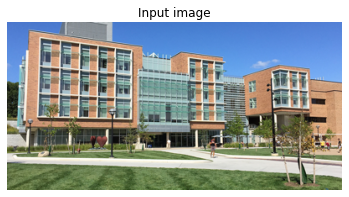

In [2]:
img_url = 'https://www.eecs.umich.edu/courses/eecs442-ahowens/pset_images/ps2/bbb-1000.jpg'
with open('bbb.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())
  
img = Image.open('bbb.jpg')
img = img.resize((400,200))
img=np.array(img)

plt.figure()
plt.title('Input image')
plt.axis('off')
plt.imshow(img)

In [150]:
def pyramid_upsample(img, kernel_size=(5,5)):
    """
    Upsamples the given pyramid image. 
    Input:
    - img: an image of shape M x N x C
    - kernel_size: a tuple representing the shape of the 2D kernel
    Returns: 
    - upsampled: an image represented as an array of shape 2M x 2N x C
    """
    m,n,c = img.shape
    upsampled = np.zeros([2*m,2*n,c])
    bias = round((kernel_size[0]-1)*0.5)
    v = 1
    for i in range(kernel_size[0]):
        for j in range(kernel_size[1]):
            gauss[i,j] = 4*(1/(2*np.pi*v))*np.exp(-((i-bias)**2 + (j-bias)**2)/(2*v))   
    for i in range(c):
        upsampled[0:2*m:2,0:2*n:2,i] = img[:,:,i]
        upsampled[:,:,i] = scipy.ndimage.convolve(upsampled[:,:,i],gauss)
    return upsampled

In [151]:
def pyramid_downsample(img, kernel_size=(5,5)):
    """
  Downsamples the given pyramid image.
  Input:
    - img: an image of shape M x N x C
    - kernel_size: a tuple representing the shape of the 2D kernel
  Returns: 
    - downsampled: an image of shape M/2 x N/2 x C
    """
    m,n,c = img.shape
    downsampled = np.zeros([round(0.5*m),round(0.5*n),c])
    bias = round((kernel_size[0]-1)*0.5)
    v = 1
    for i in range(kernel_size[0]):
        for j in range(kernel_size[0]):
            gauss[i,j] = 1*(1/(2*np.pi*v))*np.exp(-((i-bias)**2 + (j-bias)**2)/(2*v))   
    for i in range(c):
        tmp = scipy.ndimage.convolve(img[:,:,i],gauss)
        downsampled[:,:,i] = tmp[0:m:2,0:n:2]
    return downsampled

In [180]:
def gen_gaussian_pyramid(img, num_levels):
    """
  Generates an entire Gaussian pyramid.
  Input:
    - img: an image of shape M x N x C
    - num_levels: number of levels in the Gaussian pyramid
  Return:
    - gp: list, the generated levels (imgs) of the Gaussian pyramid
    """
  #############################################################################
  # TODO: Construct a Gaussian pyramid given a base image `img`.              #
  #############################################################################
    gp = []
    gp.append(img)
    for i in range(num_levels-1):
        gp.append(pyramid_downsample(gp[i], kernel_size=(5,5)))
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
    return gp

In [203]:
def gen_laplacian_pyramid(gp, num_levels):
    """
  Generates an entire Laplacian pyramid.
  Input:
    gp: list, levels of a Gaussian pyramid
  Return:
    lp: list, the generated levels (imgs) of the Laplacian pyramid
    """
  #############################################################################
  # TODO: Construct a Laplacian pyramid given final level of the Gaussian pyramid.   #
  #       The 0th element of lp should be the output of the Gaussian pyramid. #
  #############################################################################
    lp = []
    lp.append(gp[num_levels-1])
    for i in range(num_levels-1,0,-1):
        Fk=pyramid_upsample(gp[i], kernel_size=(5,5))
        lp.append(gp[i-1]-Fk)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
    return lp

In [205]:
def reconstruct_img(lp):
    """
  Reconstructs an image using a laplacian pyramid.
  Input:
    lp: list, levels (imgs) of a Laplacian pyramid
  Return:
    recon_img: reconstructed image
    """
    recon_img = lp[0]
    for i in range(1, len(lp)):
    ###########################################################################
    # TODO: For each level, reconstruct the image from the Laplacian pyramid. #
    ###########################################################################
        recon_img = pyramid_upsample(recon_img, kernel_size=(5,5))
        recon_img = recon_img + lp[i]
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return recon_img

Gaussian pyramid:
Level 0: (200, 400, 3)


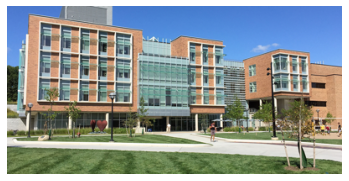

Level 1: (100, 200, 3)


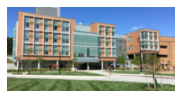

Level 2: (50, 100, 3)


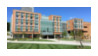

Level 3: (25, 50, 3)


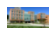

Laplacian pyramid:
Level 0: (25, 50, 3)


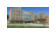

Level 1: (50, 100, 3)


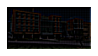

Level 2: (100, 200, 3)


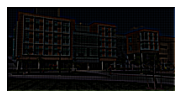

Level 3: (200, 400, 3)


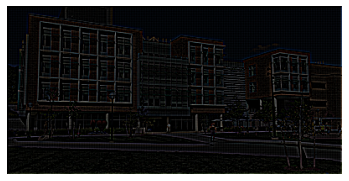

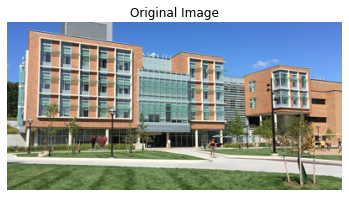

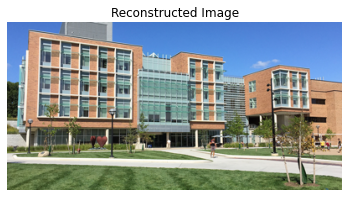

In [207]:
# Run above functions and visualize results on bbb.jpg

img = img.astype('float')

num_levels = 4 # including the original img
gp = gen_gaussian_pyramid(img, num_levels)
lp = gen_laplacian_pyramid(gp, num_levels)
recon_img = reconstruct_img(lp)

print("Gaussian pyramid:")

for i, level in enumerate(gp):
  
  level=(level-np.amin(level))/(np.amax(level)-np.amin(level))

  plt.figure(figsize=[plt.rcParams.get('figure.figsize')[0]/(2**i),plt.rcParams.get('figure.figsize')[1]/(2**i)])
  plt.axis('off')
  print("Level {}:".format(i),level.shape)
  plt.imshow(level)
  plt.show()


print("Laplacian pyramid:")
for i, level in enumerate(lp):
  
  level_plot=level.clip(0, 255).astype('uint8')

  plt.figure(figsize=[plt.rcParams.get('figure.figsize')[0]/(2**(num_levels-i-1)),plt.rcParams.get('figure.figsize')[1]/(2**(num_levels-i-1))])
  plt.axis('off')
  print("Level {}:".format(i),level.shape)
  plt.imshow(level_plot)
  plt.show()

img=img.astype(np.uint8)
plt.figure()
plt.title("Original Image")
plt.axis('off')
plt.imshow(img)

recon_img=recon_img.astype(np.uint8)
plt.figure()
plt.title("Reconstructed Image")
plt.axis('off')
plt.imshow(recon_img)

## (b) Blending two images
In this problem, we blend an image of an orange and an apple.

In [359]:
# Download the `orange.jpg` and `apple.jpg` images.
base_url = 'https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-acr/img/multires1/'
for name in ['orange.jpg', 'apple.jpg']:
  with open(name, 'wb') as out:
    url = os.path.join(base_url, name)
    out.write(urllib.request.urlopen(url).read())

# Resize images and create the image mask.
img1 = Image.open('apple.jpg')
img2 =Image.open('orange.jpg')

width,height=img1.size
new_width,new_height=width//2,height//2

img1 = img1.resize((new_width,new_height))
img1=np.array(img1)

img2 = img2.resize((new_width,new_height))
img2=np.array(img2)

mask = np.zeros_like(img1)
mask[:,:mask.shape[1]//2, :] = 1

In [360]:
def pyramid_blend(img1, img2, mask, num_levels=6):
    """
  This function produces the Laplacian pyramid blend of two images.
  Input:
    - img1: N x M x C uint8 array image
    - img2: N x M x C uint8 array image
    - mask: N x M array, all elements are either 0s or 1s
    - num_levels: int, height of the pyramid
  Return:
    - img_blend: the blended image, an N x M x C uint8 array
    """
  # Build Gaussian pyramids for img1, img2, and mask
    gp1, gp2, gpm = gen_gaussian_pyramid(img1, num_levels), gen_gaussian_pyramid(img2, num_levels), gen_gaussian_pyramid(mask, num_levels)

  # Build Laplacian pyramids for img1 and img2 
    lp1, lp2, lpm = gen_laplacian_pyramid(gp1, num_levels), gen_laplacian_pyramid(gp2, num_levels), gen_laplacian_pyramid(gpm, num_levels)

  #############################################################################
  # TODO: Construct the Laplacian pyramid and use it to blend the images.     #
  #############################################################################
    Lk = []
    count = num_levels - 1
    for i in range(num_levels):
        Lk.append(lp1[i]*gpm[count]+lp2[i]*(1-gpm[count]))
        count = count - 1
    img_blend = reconstruct_img(Lk)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

    return img_blend

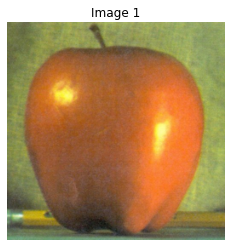

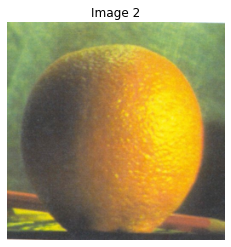

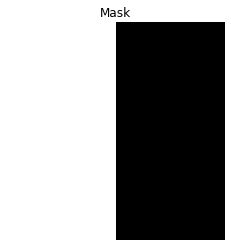

In [361]:
# Display images and mask

# Plotting image 1 - Apple
plt.figure()
plt.title('Image 1')
plt.axis('off')
plt.imshow(img1)

# Plotting image 2 - Orange
plt.figure()
plt.title('Image 2')
plt.axis('off')
plt.imshow(img2)

# Plotting the mask
plt.figure()
plt.title('Mask')
plt.axis('off')
plt.imshow(mask * 255)

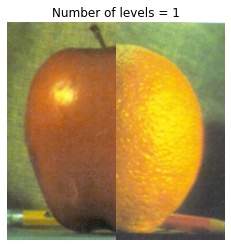

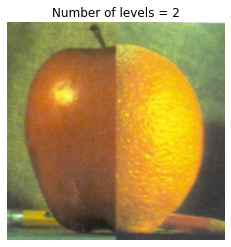

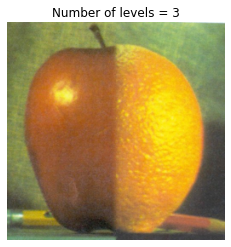

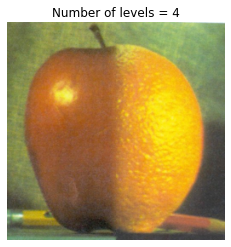

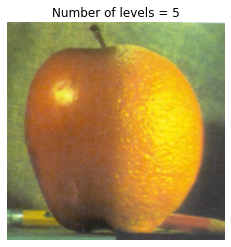

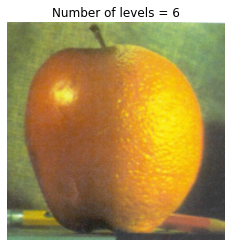

In [362]:
# Visualize Laplacian pyramid blend by varying number of levels
for n_l in range(1, 7):
  img_blend = pyramid_blend(img1.astype(float), img2.astype(float), mask.astype(float), num_levels=n_l)
  img_blend=img_blend.astype(np.uint8)
  plt.figure()
  plt.title('Number of levels = {}'.format(n_l))
  plt.axis('off')
  plt.imshow(img_blend)

# Problem 2.2: 2D DFT and the Convolution Theorem 



## (b) 
In this problem, we compare the output of a Gaussian filter through i) direct convolution in the spatial domain and ii) multiplication in the frequency domain.

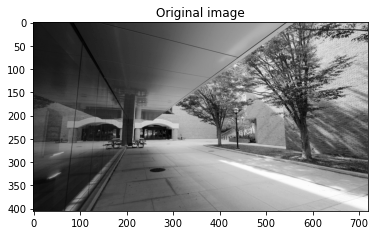

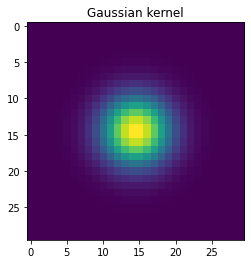

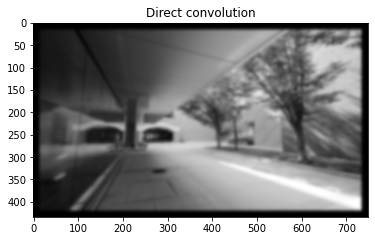

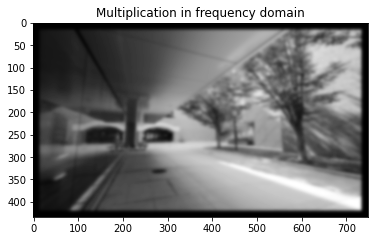

In [325]:
img_url = 'https://mapproxy.studentlife.umich.edu/images/electrical-engineering-and-computer-science-bld/XP2S3935.jpg'
with open('eecs.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())


img=Image.open('eecs.jpg').convert('L') #Here, we are converting the RGB image into a grayscale
width,height=img.size
new_width,new_height=width//2,height//2

img = img.resize((new_width,new_height))
img=np.array(img)


plt.figure()
plt.imshow(img,cmap='gray')
plt.title('Original image')
plt.show()

# Make a 2-D kernel Gaussian kernel
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
plt.imshow(kernel)
plt.title('Gaussian kernel')
plt.show()
  
# Convolution in spatial domain
#############################################################################
# TODO: Convolve the gaussian filter with the image in the spatial domain.  #
#############################################################################
img1 = scipy.signal.convolve2d(img, kernel)
#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################
plt.figure()
plt.title('Direct convolution')
plt.imshow(img1, cmap='gray')
plt.show()

# Multiplication in frequency domain
# This shape needs to be passed into the fft2 function
shape = (img.shape[0]+kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1)
#############################################################################
# TODO: Use the convolution theorem to convolve the provided image with     #
#       a Gaussian filter.                                                  #
#############################################################################
img_fft = np.fft.fft2(img,s=shape)
kernel_fft = np.fft.fft2(kernel,s=shape)
filtered_fft = img_fft * kernel_fft
img2 = np.fft.ifft2(filtered_fft)
#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################
plt.figure()
plt.title('Multiplication in frequency domain')
plt.imshow(img2.real, cmap='gray')
plt.show()

# Problem 2.3 JPEG: Image Compression

## (a) Basis for 2D Discrete Cosine Transform

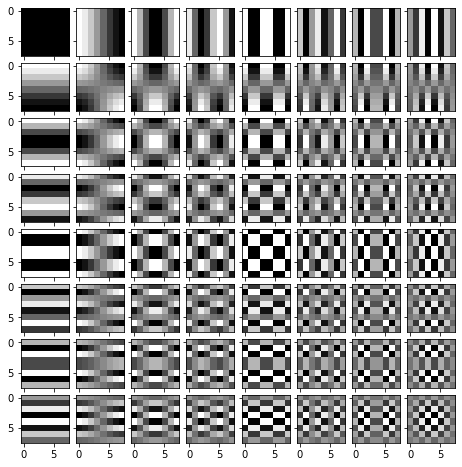

In [377]:
import numpy as np

def build_2D_DCT_basis(Nx, Ny):
  #Create 2D coordinate grid
    X = np.arange(Nx)[None,:].repeat(Ny,axis=0)
    Y = np.arange(Ny)[:,None].repeat(Nx,axis=1)

    DCT_basis = np.zeros([Ny,Nx,Ny,Nx]) # First two indices correspond to frequency components (ky,kx), last two indices correspond to spatial location (y,x).
    for kx in range(Nx):
        for ky in range(Ny):
      #############################################################################
      # TODO: Fill in DCT_basis's frequency components as defined in the HW.      #
      #############################################################################
            DCT_basis[ky,kx,:,:] =np.cos((np.pi/(2*Nx))*(2*X+1)*kx) * np.cos((np.pi/(2*Ny))*(2*Y+1)*ky)
      #############################################################################
      #                              END OF YOUR CODE                             #
      #############################################################################
    return DCT_basis

# Build the DCT basis and visualize it.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

Nx, Ny = 8, 8
DCT_basis = build_2D_DCT_basis(Nx, Ny)
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(Ny, Nx),  # creates a grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, DCT_basis.reshape(-1,Ny,Nx)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
plt.show()


##  (b) 2D Discrete Cosine Transform
**(Optional to read, but please run this cell)**

In [378]:
def DCT_2D(image_patch):
  """
  2D DCT transform of image patch of shape (H,W)
  """
  H,W = image_patch.shape
  DCT_basis = build_2D_DCT_basis(W,H)
  DCT_coeffcients = np.zeros([H,W])
  
  for h in range(H):
    for w in range(W):
      norm_const_h = 1/np.sqrt(H) if h == 0 else np.sqrt(2/H)
      norm_const_w = 1/np.sqrt(W) if w == 0 else np.sqrt(2/W)
      DCT_coeffcients[h,w] = norm_const_h * norm_const_w * (DCT_basis[h, w] * image_patch).sum()
  return DCT_coeffcients

def IDCT_2D(image_spectrum):
  """
  2D inverse DCT trasform.
  """
  H,W = image_spectrum.shape
  DCT_basis = build_2D_DCT_basis(W,H)
  image = np.zeros([H,W])
  norm_matrix = 1/np.sqrt(H*W) * np.ones([H,W])
  norm_matrix[1:,0] *= np.sqrt(2)
  norm_matrix[0,1:] *= np.sqrt(2)
  norm_matrix[1:,1:] *= 2

  for h in range(H):
    for w in range(W):
      norm_const_h = 1/np.sqrt(H) if h == 0 else np.sqrt(2/H)
      norm_const_w = 1/np.sqrt(W) if w == 0 else np.sqrt(2/W)
      image += norm_const_h * norm_const_w * (DCT_basis[h, w] * image_spectrum[h,w])
  return image
 
image_patch = np.random.rand(8,8)
# Verify above gives same result as using scipy fftpack
from scipy import fftpack
def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')
def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')
print(np.abs(DCT_2D(image_patch) - dct_2d(image_patch)).sum())
print(np.abs(IDCT_2D(image_patch) - idct_2d(image_patch)).sum())

3.835126660689525e-14
2.74051614734816e-14


## (c) JPEG Image Compression

In [380]:
#Download the image to be compressed
!wget -O original.png "https://docs.google.com/uc?export=download&id=1Ww2zAALWCuOmDbYw1XM5ACmFgIA8u6_9"

--2022-09-16 15:21:48--  https://docs.google.com/uc?export=download&id=1Ww2zAALWCuOmDbYw1XM5ACmFgIA8u6_9
Resolving docs.google.com (docs.google.com)... 172.217.5.14, 2607:f8b0:4009:81c::200e
Connecting to docs.google.com (docs.google.com)|172.217.5.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/44q1j4kit78r5h19pdis7ru15t9bqmgk/1663356075000/11328405491383495500/*/1Ww2zAALWCuOmDbYw1XM5ACmFgIA8u6_9?e=download&uuid=c50b82be-965f-4fd4-af73-2ced1f859d4d [following]
--2022-09-16 15:21:48--  https://doc-0s-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/44q1j4kit78r5h19pdis7ru15t9bqmgk/1663356075000/11328405491383495500/*/1Ww2zAALWCuOmDbYw1XM5ACmFgIA8u6_9?e=download&uuid=c50b82be-965f-4fd4-af73-2ced1f859d4d
Resolving doc-0s-7s-docs.googleusercontent.com (doc-0s-7s-docs.googleusercontent.com)... 142.250.191.129, 2607:f8b0:4009:818::2001

### Utility functions
We will first define some utility functions. You don't need to implement anything in this block or read all of its details. 
The only important functions in this part you may want to look at to understand better are `quantize` and `load_quantization_table`. 

In [381]:
# We will first define some utility functions. You don't need to implement anything in this block or read all of its details. 
# The only important functions in this part you may want to look at to understand better are 'quantize' and 'load_quantization_table'. 
# Code in this part is based on https://github.com/ghallak/jpeg-python
from queue import PriorityQueue
class HuffmanTree:
  """
  Class for creating Huffman Table, given an input array. The huffman encodes
  input data based on their appearance frequency, 
  i.e., assign a shorter code for more frequently appearing values.
  """
  def __init__(self, arr):
      q = PriorityQueue()
      # calculate frequencies and insert them into a priority queue
      for val, freq in self.__calc_freq(arr).items():
          q.put(self.__Node.init_leaf(val, freq))
      while q.qsize() >= 2:
          u = q.get()
          v = q.get()
          q.put(self.__Node.init_node(u, v))
      self.__root = q.get()
      # dictionaries to store huffman table
      self.__value_to_bitstring = dict()

  def value_to_bitstring_table(self):
      if len(self.__value_to_bitstring.keys()) == 0:
          self.__create_huffman_table()
      return self.__value_to_bitstring

  def __create_huffman_table(self):
      def tree_traverse(current_node, bitstring=''):
          if current_node is None:
              return
          if current_node.is_leaf():
              self.__value_to_bitstring[current_node.value] = bitstring
              return
          tree_traverse(current_node.left_child, bitstring + '0')
          tree_traverse(current_node.right_child, bitstring + '1')

      tree_traverse(self.__root)

  def __calc_freq(self, arr):
      freq_dict = dict()
      for elem in arr:
          if elem in freq_dict:
              freq_dict[elem] += 1
          else:
              freq_dict[elem] = 1
      return freq_dict

  class __Node:
      def __init__(self, value, freq, left_child, right_child):
          self.value = value
          self.freq = freq
          self.left_child = left_child
          self.right_child = right_child

      @classmethod
      def init_leaf(cls, value, freq):
          return cls(value, freq, None, None)

      @classmethod
      def init_node(cls, left_child, right_child):
          freq = left_child.freq + right_child.freq
          return cls(None, freq, left_child, right_child)

      def is_leaf(self):
          return self.value is not None

      def __eq__(self, other):
          stup = self.value, self.freq, self.left_child, self.right_child
          otup = other.value, other.freq, other.left_child, other.right_child
          return stup == otup

      def __nq__(self, other):
          return not (self == other)

      def __lt__(self, other):
          return self.freq < other.freq

      def __le__(self, other):
          return self.freq < other.freq or self.freq == other.freq

      def __gt__(self, other):
          return not (self <= other)

      def __ge__(self, other):
          return not (self < other)

def load_quantization_table(component):
    # Quantization tables determine how much DCT coefficents are divided during
    # quantization. Larger value means it is more likely to be a 0 after division. 
    # Setting large values like 100000 means that frequency component is set to 0 for sure. 
    if component == 'dc_only':
        q = np.array([[1, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]])           
    elif component == 'first_3':
        q = np.array([[1, 1, 100000, 100000, 100000, 100000, 100000, 100000],
                      [1, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]]) 
    elif component == 'first_6':
        q = np.array([[1, 1, 1, 100000, 100000, 100000, 100000, 100000],
                      [1, 1, 100000, 100000, 100000, 100000, 100000, 100000],
                      [1, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]])
    elif component == 'first_10':
        q = np.array([[1, 1, 1, 1, 100000, 100000, 100000, 100000],
                      [1, 1, 1, 100000, 100000, 100000, 100000, 100000],
                      [1, 1, 100000, 100000, 100000, 100000, 100000, 100000],
                      [1, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000],
                      [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]]) 
    #q1 and q2 are some more realistic quantization values. You can try these, but no need to report any result from using 'q1' or 'q2'.
    elif component == 'q1':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
        
    elif component == 'q2':
        q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                      [12, 12, 14, 19, 26, 58, 60, 55],
                      [14, 13, 16, 24, 40, 57, 69, 56],
                      [14, 17, 22, 29, 51, 87, 80, 62],
                      [18, 22, 37, 56, 68, 109, 103, 77],
                      [24, 35, 55, 64, 81, 104, 1113, 92],
                      [49, 64, 78, 87, 103, 121, 120, 101],
                      [72, 92, 95, 98, 112, 100, 103, 99]])                     
    else:
        raise ValueError((
            "Unrecognized compoents,'{comp}' was found").format(comp=component))
    return q

def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols
    # start in the top-left cell
    point = (0, 0)
    # True when moving up-right, False when moving down-left
    move_up = True
    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)

def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result

def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))

def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)

def int_to_binstr(n):
    if n == 0:
        return ''
    binstr = bin(abs(n))[2:]
    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)

def flatten(lst):
    return [item for sublist in lst for item in sublist]


#Utility functions for encoding and writing to files below
def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)

def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])

def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values

def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e
    #f.write('1')
    for table_name in ['dc_y', 'ac_y']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name == 'dc_y':
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))
    for b in range(blocks_count):
        for c in range(1):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] 
            ac_table = tables['ac_y']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))
            #bit_count_ac = 0
            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
                #bits_written = len(ac_table[tuple(symbols[i])]) + len(values[i])
                #bit_count_ac += bits_written
            #print('Block {}:{} bits'.format(b,bit_count_ac))
    f.close()

def HuffmanEncode_im(filepath, im):
    """Huffman encoding the gray scale image directly.

    Args:
        filepath : [Location to save the encoded file]
        im ([numpy array]): Shape (H,W)
    """
    im = im.flatten()
    pixel_count = len(im)
    f = open(filepath,'w')
    H_Tree = HuffmanTree(im.flatten())
    H_table = H_Tree.value_to_bitstring_table()

    # 16 bits for 'table_size'
    f.write(uint_to_binstr(len(H_table), 16))

    for key, value in H_table.items():
            # 4 bits for the 'category'
            # 4 bits for 'code_length'
            # 'code_length' bits for 'huffman_code'
            f.write(uint_to_binstr(key, 4))
            f.write(uint_to_binstr(len(value), 4))
            f.write(value)

    # 32 bits for 'pixel_count'
    f.write(uint_to_binstr(pixel_count, 32))
    for item in im:
        f.write(H_table[item])
    f.close()

def write_as_binary(string_file_path, output_file_path):

    f = open(string_file_path,'r')
    binary_string = f.read()
    f_binary = open(output_file_path,mode='wb')
    #Remainder bits are not written for simplicity.
    for i in range(len(binary_string) // 8):
        byte = bytes([int(binary_string[8*i:8*i+8],2)])
        f_binary.write(byte)

    f.close()
    f_binary.close()


# Utility functions for decode
class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0
        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 1), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 1), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(1):
            dc_table = tables['dc_y'] 
            ac_table = tables['ac_y'] 

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)
            cells_count = 0

            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block

def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q

### Encoding and Decoding

Finished encoding and writing data to file.
Orignal image size is 226 kB
Compressed file size is 36 kB
Compression ratio is 0.16
Finished decoding file.


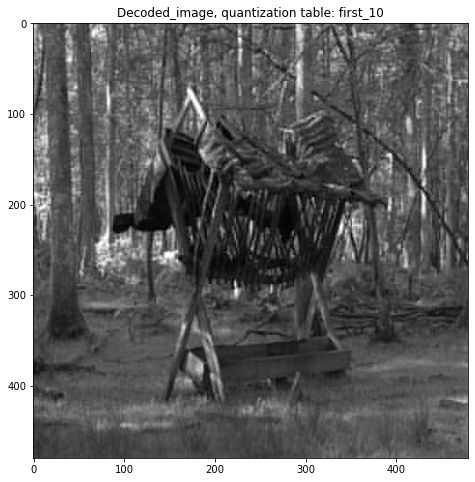

In [388]:
# Encoding

# Path to the input image file to be compressed.
input_file = './original.png'
# Path for the encoded code file.
output_file = './encoded_as_string'

#############################################################################
# TODO: Specify the quantization table to use here.                         #
# Your options: 'dc_only','first_3', 'first_6', 'first_10'                  #
#############################################################################
quantization_table = 'first_10'
#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

image = Image.open(input_file)
npmat = np.array(image, dtype=np.int16)[:,:,None]

rows, cols = npmat.shape[0], npmat.shape[1]

# block size: 8x8
if rows % 8 == cols % 8 == 0:
    blocks_count = rows // 8 * cols // 8
else:
    raise ValueError(("the width and height of the image should both be mutiples of 8"))

# dc is the top-left cell of the block, ac are all the other cells
dc = np.empty((blocks_count, 1), dtype=np.int32)
ac = np.empty((blocks_count, 63, 1), dtype=np.int32)
block_index = 0

for i in range(0, rows, 8):
    for j in range(0, cols, 8):
        for k in range(1):
            # split 8x8 block and center the data range on zero
            # [0, 255] --> [-128, 127]
            block = npmat[i:i+8, j:j+8, k] - 128
            dct_matrix = DCT_2D(block)
            quant_matrix = quantize(dct_matrix,quantization_table)
            zz = block_to_zigzag(quant_matrix)

            dc[block_index, k] = zz[0]
            ac[block_index, :, k] = zz[1:]

        block_index += 1

H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
H_AC_Y = HuffmanTree(flatten(run_length_encode(ac[i, :, 0])[0] for i in range(blocks_count)))

tables = {'dc_y': H_DC_Y.value_to_bitstring_table(), 'ac_y': H_AC_Y.value_to_bitstring_table()}

write_to_file(output_file, dc, ac, blocks_count, tables)
write_as_binary(output_file, 'encoded_as_binary')

print('Finished encoding and writing data to file.')


# Printing the original image size and compressed file size
file_name = "original.png"
file_stats = os.stat(file_name)
size_ori = file_stats.st_size / (1024)
print('Orignal image size is {:.0f} kB'.format(size_ori))
file_name = "encoded_as_binary"
file_stats = os.stat(file_name)
size_compressed = file_stats.st_size / (1024)
print('Compressed file size is {:.0f} kB'.format(size_compressed))
print('Compression ratio is {:.2f}'.format(size_compressed/size_ori))

# Decoding

# Path to the encoded as string file.
encoded_string_file = 'encoded_as_string'

dc, ac, tables, blocks_count = read_image_file(encoded_string_file)
# Assuming that the block is a 8x8 square
block_side = 8

# Assuming that the image height and width are equal
image_side = int(math.sqrt(blocks_count)) * block_side
blocks_per_line = image_side // block_side
npmat = np.empty((image_side, image_side, 1), dtype=np.uint8)

for block_index in range(blocks_count):
    i = block_index // blocks_per_line * block_side
    j = block_index % blocks_per_line * block_side
    for c in range(1):
        zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
        quant_matrix = zigzag_to_block(zigzag)
        dct_matrix = dequantize(quant_matrix, quantization_table)
        block = IDCT_2D(dct_matrix)
        npmat[i:i+8, j:j+8, c] = (block + 128).clip(0,255)

print('Finished decoding file.')
plt.figure(figsize=(8,8))
plt.imshow(npmat[:,:,0],cmap='gray')
plt.title('Decoded_image, quantization table: '+quantization_table)
image = Image.fromarray(npmat[:,:,0], 'L')
image.save('Decoded.png', compress_level=0)

### **(Optional)** Direct Huffman encoding the image, without DCT. 



In [ ]:
Direct_encoding_save_name = 'Direct_im_huffman_encoded_as_string'
HuffmanEncode_im(Direct_encoding_save_name, npmat[:,:,0])
write_as_binary(Direct_encoding_save_name, 'Direct_im_huffman_encoded_as_binary')

file_name = 'Direct_im_huffman_encoded_as_binary'
file_stats = os.stat(file_name)
size_direct = file_stats.st_size / (1024)
print('Direct Huffman coded file size is {:.0f} kB'.format(size_direct))


# Convert Notebook to PDF

In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS2_FA_2022_Starter_Code.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')